# Visualization for Raw Data

## Loading and Balancing Data

In [55]:
import os
import glob
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Remove grid style by setting a minimal style
sns.set_style("white")  # "white" gives a clean background without gridlines

# Define the path to your data folder
data_folder = "./dataset/train"  # <-- Change this to your actual data path

# Define the order of keywords to search (reverse priority: start with 'falldown', then 'downstair', etc.)
categories = ["falldown","shaking","downstair", "upstair", "jogging", "walking"]

# Define a custom palette for the categories
# custom_palette = {
#     "falldown": "#519D78",
#     "shaking": "#5385BD",
#     "downstair": "#8BCF8B",
#     "upstair": "#9BC7DF",
#     "jogging": "#AADCA9",
#     "walking": "#DFF3F8",
# }
# Final Ver

# custom_palette = {
#     "falldown": "#ff4495",
#     "shaking": "#ffd644",
#     "downstair": "#008ECF",
#     "upstair": "#00B6DD",
#     "jogging": "#BBE1F5",
#     "walking": "#89E3FF",
# }
custom_palette = {
    "falldown": "#A3EEFE",
    "shaking": "#D3F3FF",
    "downstair": "#ABAAFE",
    "upstair": "#D3D1FE",
    "jogging": "#FFBEF9",
    "walking": "#FDE3FE",
}
#荧光色
# custom_palette = {
#     "falldown": "#DE4D0B",
#     "shaking": "#352860",
#     "run": "#84F65A",
#     "downstair":"#B9EB3D",
#     "upstair": "#54F281",
#     "jogging": "#30DCBC",
#     "walking": "#29B6DD",
#     "bicycle":"#3C8CE8"
# }
# custom_palette = {
#     "falldown": "#DAEDEC",
#     "shaking": "#352860",
#     "run": "#DAEDEC",
#     "downstair":"#98CCD0",
#     "upstair": "#E2E9CE",
#     "jogging": "#30DCBC",
#     "walking": "#CCDC9E",
#     "bicycle":"#A1C256"
# }

# Dictionary to store data for each label
label_data = {}

# Get all CSV files in the folder
file_list = glob.glob(os.path.join(data_folder, "*.csv"))
print(f"Found {len(file_list)} CSV files.")

for file_path in file_list:
    filename = os.path.basename(file_path).lower()

    # Determine the label by checking keywords in the specified order
    label_found = None
    for cat in categories:
        if cat in filename:
            label_found = cat
            break
    if label_found is None:
        label_found = "unknown"

    # Read the CSV while skipping the first row
    # Assuming each CSV file has 7 columns: the first is time-step (to skip), and the next 6 are sensor data
    df = pd.read_csv(file_path, skiprows=1, header=None)

    # Skip the first column (time-step) and take the next 6 columns
    sensor_data = df.iloc[:, 1:7].values  # shape (num_samples_in_file, 6)

    # Store in the dictionary
    if label_found not in label_data:
        label_data[label_found] = []
    label_data[label_found].append(sensor_data)

# Combine arrays for each label
for lbl in label_data:
    # Stack all arrays for that label
    label_data[lbl] = np.vstack(label_data[lbl])  # shape (N, 6)

# Find the minimum number of samples among the known classes (excluding 'unknown')
known_labels = [lbl for lbl in label_data if lbl != "unknown"]
min_count = min(len(label_data[lbl]) for lbl in known_labels)

# Undersample each known label to the min_count
balanced_data = []
balanced_labels = []
for lbl in known_labels:
    data_for_label = label_data[lbl]
    # Randomly choose min_count samples
    indices = np.random.choice(len(data_for_label), size=min_count, replace=False)
    sampled = data_for_label[indices]
    
    balanced_data.append(sampled)
    balanced_labels.append([lbl]*min_count)

# Concatenate all balanced data
X = np.vstack(balanced_data)  # shape (total_balanced_samples, 6)
labels = np.concatenate(balanced_labels)  # shape (total_balanced_samples, )

print("Balanced data shape:", X.shape)
print("Balanced labels shape:", labels.shape)


Found 199 CSV files.
Balanced data shape: (8280, 6)
Balanced labels shape: (8280,)


## UMap

/opt/anaconda3/envs/nnenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (8280, 2)


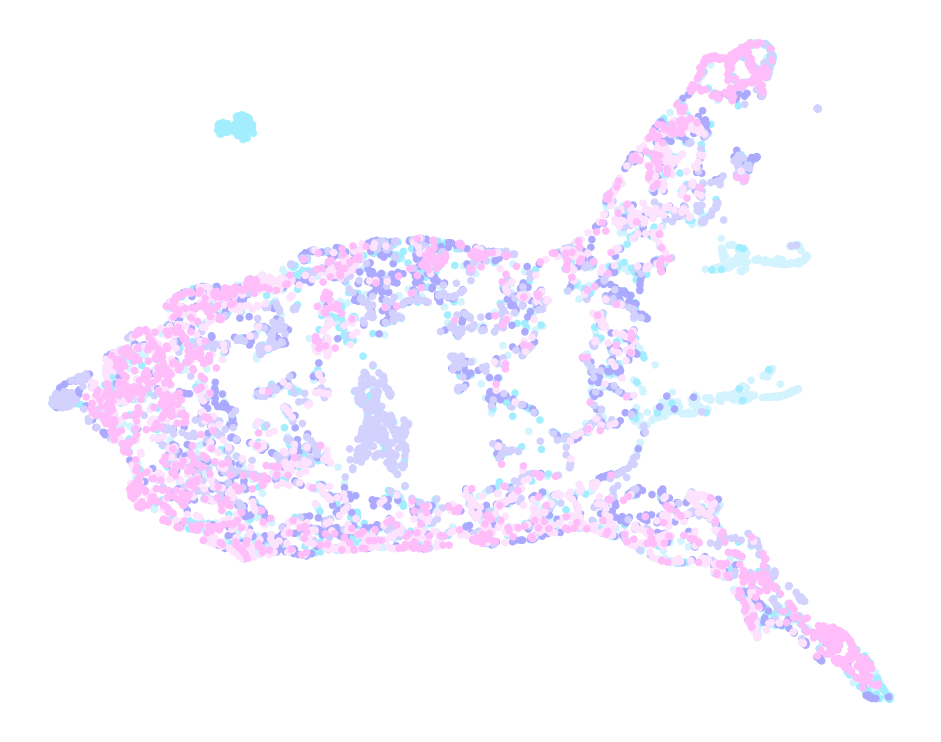

In [56]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Remove grid style by setting a minimal style
sns.set_style("white")  # Ensures a clean background

# Run UMAP on the 6-dimensional sensor data
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(X)

print("UMAP embedding shape:", embedding.shape)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 26
# If you want the math text (like exponents) to also be in Arial-like style:
plt.rcParams["mathtext.fontset"] = "dejavusans"  # or "stix", "custom", etc.

# Plot the 2D UMAP results with the custom palette
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=labels,
    palette=custom_palette,
    alpha=1,
    edgecolor="none",
    s=30
)

plt.xticks([])  # Removes x-axis labels
plt.yticks([]) 
plt.legend([],frameon = False)
# plt.legend(
#     bbox_to_anchor=(0.95, 1),
#     loc='upper left',
#     frameon=False,  # <--- Turn off legend box,
# )

ax = plt.gca()  # Get current axes
# for spine in ax.spines.values():    
#         spine.set_linewidth(1.5)  # Set the desired border width
# Remove top and right spines (the 'frame')
sns.despine(left=True, right=True, top=True, bottom=True)


plt.tight_layout()
plt.savefig("umap_plot.png", transparent=True)
plt.show()


